
# LAB 3: Feature Detection and Matching

1. What are features?

  To analyze and classify images, it is necessary to extract relevant features from the pixels. These features can include textures, shapes, colors, etc., which are often transformed into vectors of numerical descriptors.

  - Corners: Detected by Harris, FAST, and SIFT.
  - Edges: Often detected using Canny or Sobel as preprocessing steps, though SIFT also uses edge information.
  - Blobs: Detected by SIFT, SURF, KAZE, AKAZE, and MSER.
2. Implement Haris corner detection.
3. Implementation of Hough Transform.
4. Implement SIFT (Scale-Invariant Feature Transform).
5. Implement custom sequential model such as VGG for feature extraction.

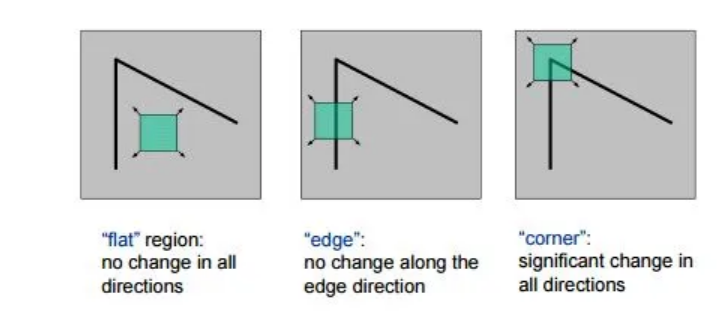

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# 1. Haris corner detection

1. Gradient Computation: Calculate the image gradients in the x and y directions (using operators like Sobel) to determine intensity changes.
2. Structure Tensor Formation: For each pixel, build the second-moment matrix (or structure tensor) by combining the squared gradients and their product, typically weighted by a Gaussian window.
3. Corner Response Calculation: Compute the corner response using the Harris function:

    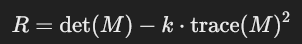

  where MM is the structure tensor and kk is a sensitivity parameter.
4. Thresholding: Apply a threshold to the response values to filter out low responses, keeping only the potential corner candidates.
5. Non-Maximum Suppression and Localization: Perform non-maximum suppression to isolate distinct corners by selecting only the local maxima in the response map, finalizing the corner locations.

Load the image

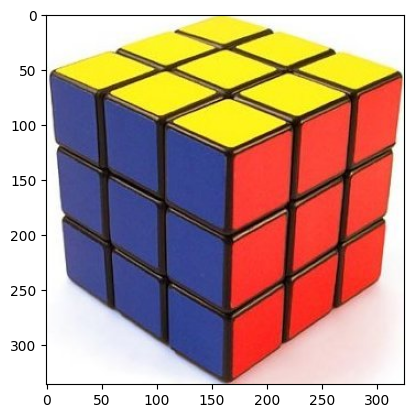

In [2]:
# Read in the image
image = cv2.imread('./imgA.jpg')

# Make a copy of the image
image_Copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_Copy, cv2.COLOR_BGR2RGB)

plt.imshow(image_copy)

Detect the corners

https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

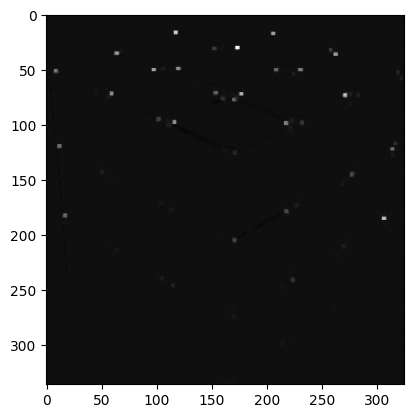

In [3]:
# Convert to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

# Detect corners
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Enhance corner points
dst = cv2.dilate(dst,None)

plt.imshow(dst, cmap='gray')


Extract and display strong corners

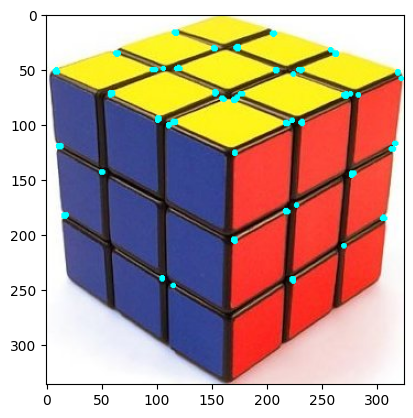

In [14]:
# This value vary depending on the image and how many corners you want to detect
# Try changing this free parameter, 0.1, to be larger or smaller and see what happens
threshold = 0.05*dst.max()

# Create an image copy to draw corners on
corner_image = np.copy(image_copy)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > threshold):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,255), 1)

plt.imshow(corner_image)

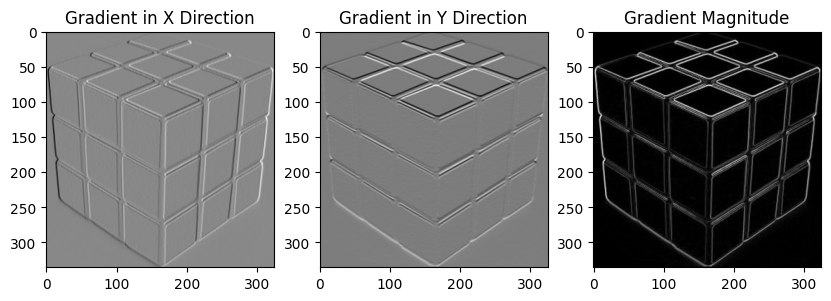

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image and convert to grayscale
image = cv2.imread('./imgA.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute gradients using Sobel operator
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction

# Compute gradient magnitude
magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Normalize magnitude for visualization
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Gradient in X Direction")
plt.imshow(grad_x, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Gradient in Y Direction")
plt.imshow(grad_y, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Gradient Magnitude")
plt.imshow(magnitude, cmap='gray')
plt.show()


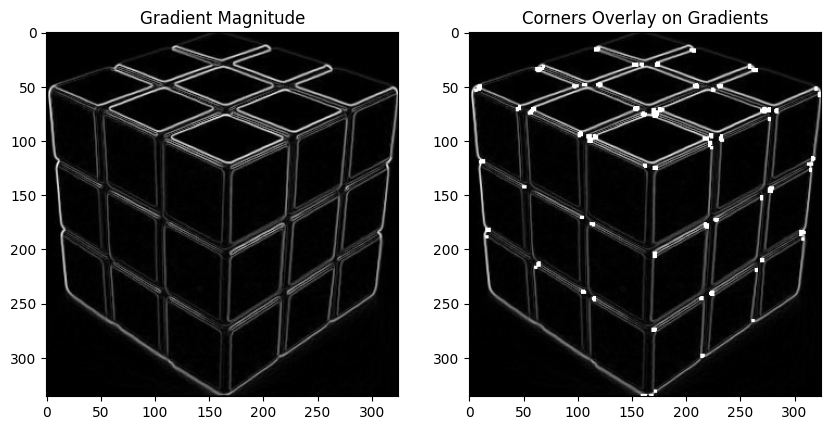

In [16]:
# Detect corners using Harris corner detection
dst = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
dst = cv2.dilate(dst, None)

# Threshold to find strong corners
threshold = 0.01 * dst.max()
corners = dst > threshold

# Create a copy of the gradient magnitude to overlay corners
overlay = np.copy(magnitude)
overlay[corners] = 255  # Highlight corners

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Gradient Magnitude")
plt.imshow(magnitude, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Corners Overlay on Gradients")
plt.imshow(overlay, cmap='gray')
plt.show()


# 2. Hough Transform

1. Edge Detection:
Start by applying an edge detector (e.g., Canny or Sobel) to obtain a binary edge map that highlights potential edges.

2. Parameter Space Mapping:
Transform each edge pixel from the image space to the parameter space. For line detection, use the polar representation **ρ=xcos⁡θ+ysin⁡θ**

3. Accumulator Voting:
Each edge pixel votes for all the parameters (e.g., ρρ and θθ) that could form a line through it, incrementing the corresponding cells in an accumulator array.

4. Peak Detection:
Analyze the accumulator to identify peaks—these represent the parameter combinations (lines) that received the highest number of votes.

5. Line Extraction:
Convert the detected peaks in parameter space back to image space to extract and draw the corresponding lines or shapes.

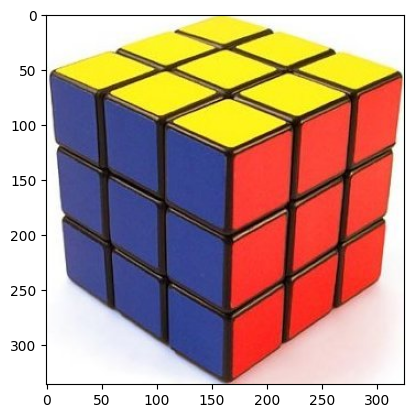

In [7]:
image = cv2.imread('imgA.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

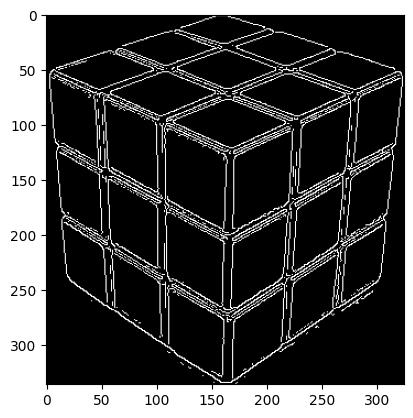

In [8]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# Define our parameters for Canny
low_threshold = 50
high_threshold = 100
edges = cv2.Canny(gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

Paramters of cv2.HoughLinesP

* rho: The distance resolution in pixels (1 pixel per unit).
* theta: The angle resolution in radians (1 degree).
* threshold: At least n edge points need to vote for a line.
* min_line_length: A valid line must be at least m pixels long.
* max_line_gap: Two line segments with a gap of x pixels or fewer are considered part of the same line.

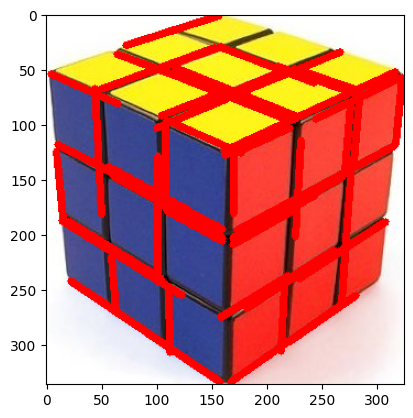

In [11]:
rho = 1
theta = np.pi/180
threshold = 60
min_line_length = 50
max_line_gap = 5
line_image = np.copy(image) #creating an image copy to draw lines on# Run Hough on the edge-detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)   # Iterate over the output "lines" and draw lines on the image copy

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

plt.imshow(line_image)

# 3. Scale-Invariant Feature Transform (SIFT)

1. Scale-Space Construction:
Build a scale-space by convolving the image with Gaussians at different scales, allowing the algorithm to detect features across various sizes.

2. Difference-of-Gaussians (DoG) Generation:
Compute the Difference-of-Gaussian images by subtracting adjacent Gaussian-blurred images. This step approximates the Laplacian of Gaussian and highlights potential keypoints.

3. Keypoint Detection:
Identify local extrema (both minima and maxima) in the DoG images across scales. These local extrema serve as candidate keypoints.

4. Keypoint Localization and Filtering:
Refine the candidate keypoints by fitting a Taylor expansion to determine accurate locations and discard points with low contrast or those poorly localized along edges.

5. Orientation Assignment:
For each keypoint, compute the gradient magnitude and orientation in its neighborhood. Assign a dominant orientation to ensure that the feature descriptor is rotation invariant.

6. Descriptor Formation:
Create a descriptor for each keypoint by dividing its neighborhood into subregions and calculating histograms of gradient orientations. This results in a robust, typically 128-dimensional, feature vector.

7. Feature Matching (Optional):
While not part of the detection process itself, these descriptors are later used to match keypoints between images, enabling tasks such as object recognition or image stitching.


https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

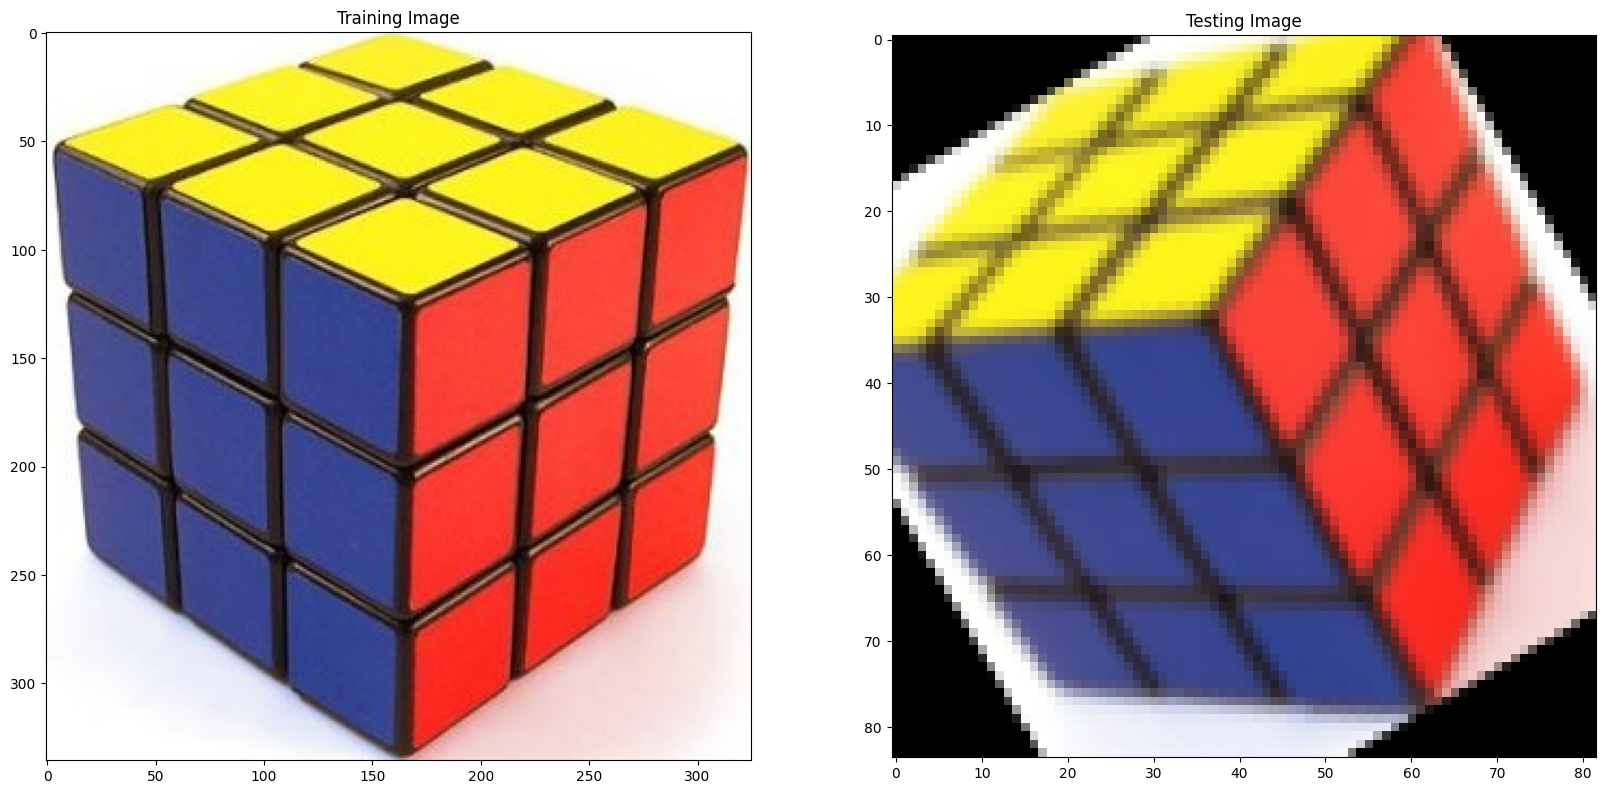

In [ ]:

# Load the image
image1 = cv2.imread('./imgA.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  265
Number of Keypoints Detected In The Query Image:  113


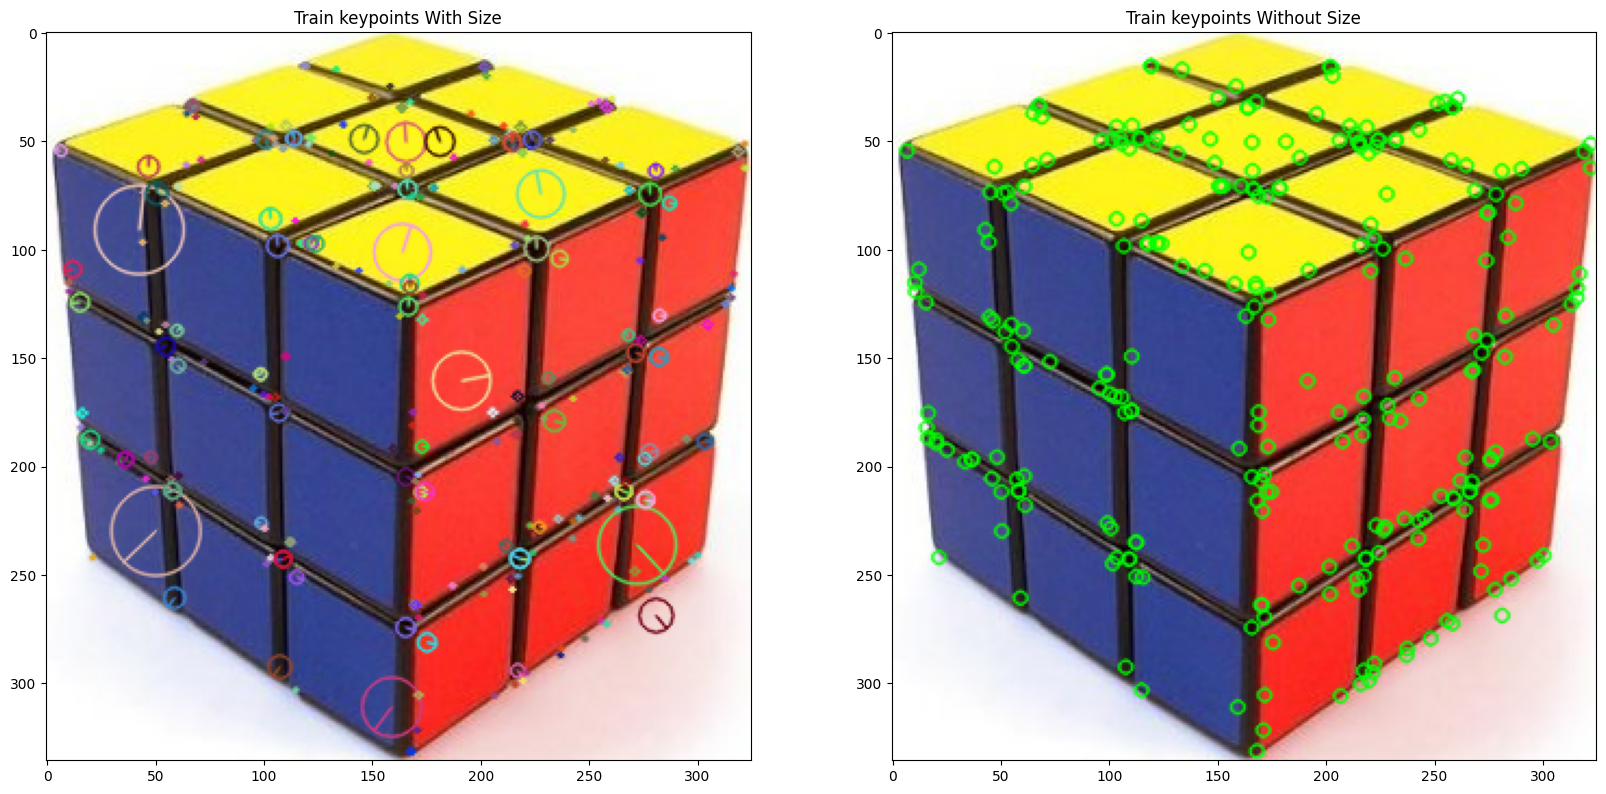

In [ ]:
# Detect keypoints and Create Descriptor
sift = cv2.xfeatures2d.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

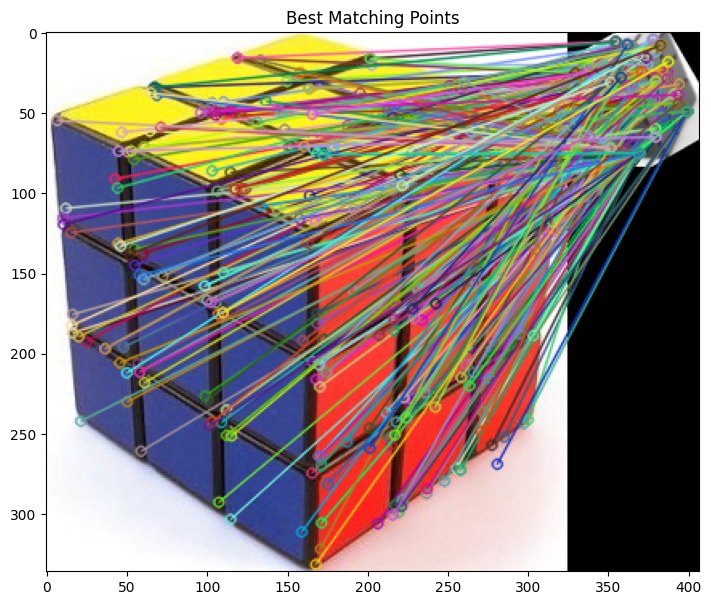


Number of Matching Keypoints Between The Training and Query Images:  265


In [ ]:
# Matching Keypoints

# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))